# Multi-layer Perceptron Classifier

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## Load Split Data

In [2]:
clean_train = "../../data/clean/clean_train.csv"
clean_val = "../../data/clean/clean_val.csv"
clean_test = "../../data/clean/clean_test.csv"
train_subsam = "../../data/clean/train_subsam.csv"
train_smote = "../../data/clean/train_smote.csv"

num_cols = ["Term","NoEmp","SecuredSBA","GrDisburs","GrApprov","ApprovSBA"]
target = "Default"

In [3]:
df_train = pd.read_csv(clean_train, low_memory=False)
df_val = pd.read_csv(clean_val, low_memory=False)
df_test = pd.read_csv(clean_test, low_memory=False)

df_under = pd.read_csv(train_subsam, low_memory=False)
df_smote = pd.read_csv(train_smote, low_memory=False)

In [4]:
X_train = df_train.drop(columns=[target])
X_val = df_val.drop(columns=[target])
X_test = df_test.drop(columns=[target])
X_under = df_under.drop(columns=target)
X_smote = df_smote.drop(columns=target)

y_train = df_train[target]
y_val = df_val[target]
y_test = df_test[target]
y_under = df_under[target]
y_smote = df_smote[target]

# from tensorflow.keras.utils import to_categorical
# y_train = to_categorical(y_train, num_classes=2)

In [5]:
print(f"Train: {X_train.shape}, {y_train.shape}")
print(f"Val:   {X_val.shape}, {y_val.shape}")
print(f"Test:  {X_test.shape}, {y_test.shape}\n")

print(f"SubSam: {X_under.shape}, {y_under.shape}")
print(f"SMOTE:  {X_smote.shape}, {y_smote.shape}")

Train: (626670, 18), (626670,)
Val:   (134552, 18), (134552,)
Test:  (134498, 18), (134498,)

SubSam: (219654, 18), (219654,)
SMOTE:  (1033686, 18), (1033686,)


## Feature Scaling

In [6]:
scaler = MinMaxScaler()

X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_val[num_cols] = scaler.fit_transform(X_val[num_cols])
X_test[num_cols] = scaler.fit_transform(X_test[num_cols])

df_under[num_cols] = scaler.fit_transform(df_under[num_cols])
df_smote[num_cols] = scaler.fit_transform(df_smote[num_cols])

X_train.sample(3)

,State,BankState,DifState,Sector,AppYear,AppMonth,Term,NoEmp,Secured,NewExist,Urban,Rural,RevLine,LowDoc,GrDisburs,GrApprov,ApprovSBA,SecuredSBA
373696,15,18,0,10,40,6,0.316344,0.0008,0,0,1,0,0,0,0.046844,0.098519,0.073929,0.742268
75786,23,31,1,13,45,7,0.042179,0.0004,0,0,1,0,1,0,0.006205,0.013526,0.006762,0.484536
267955,14,17,0,7,38,1,0.010545,0.0003,0,1,1,0,0,1,0.006205,0.013526,0.011560,0.845361


## Model Training

### Model Tuning

In [7]:
def create_model():
    model = keras.Sequential()

    model.add(layers.Dense(64, input_shape=[len(X_train.keys())], activation="relu"))
    model.add(layers.Dense(512, activation="relu"))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(1, activation="sigmoid"))

    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
    return model

In [8]:
mlp_model = create_model()

mlp_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                1216      
                                                                 
 dense_1 (Dense)             (None, 512)               33280     
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 513       
                                                                 
Total params: 35009 (136.75 KB)
Trainable params: 35009 (136.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [9]:
history = mlp_model.fit(X_train,
                        y_train,
                        epochs=100,
                        batch_size=1000,
                        verbose=1,
                        validation_data=(X_val, y_val))

Epoch 1/100
627/627 [==============================] - 17s 24ms/step - loss: 0.4431 - accuracy: 0.8176 - val_loss: 0.3856 - val_accuracy: 0.8358
Epoch 2/100
627/627 [==============================] - 13s 21ms/step - loss: 0.3681 - accuracy: 0.8408 - val_loss: 0.3560 - val_accuracy: 0.8693
Epoch 3/100
627/627 [==============================] - 13s 21ms/step - loss: 0.3366 - accuracy: 0.8615 - val_loss: 0.3189 - val_accuracy: 0.8759
Epoch 4/100
627/627 [==============================] - 15s 23ms/step - loss: 0.3220 - accuracy: 0.8698 - val_loss: 0.3208 - val_accuracy: 0.8668
Epoch 5/100
627/627 [==============================] - 14s 23ms/step - loss: 0.3145 - accuracy: 0.8737 - val_loss: 0.3130 - val_accuracy: 0.8688
Epoch 6/100
627/627 [==============================] - 15s 25ms/step - loss: 0.3078 - accuracy: 0.8769 - val_loss: 0.3003 - val_accuracy: 0.8781
Epoch 7/100
627/627 [==============================] - 15s 24ms/step - loss: 0.3037 - accuracy: 0.8791 - val_loss: 0.3052 - val_ac

In [10]:
results = mlp_model.evaluate(X_test, y_test, verbose=1)

print("Accuracy:", round(results[1], 4))

4204/4204 [==============================] - 11s 3ms/step - loss: 0.2839 - accuracy: 0.8948
Accuracy: 0.8948


In [38]:
df_hist = pd.DataFrame(history.history)
df_hist["epoch"] = history.epoch

df_hist.iloc[[0,1,-2,-1]]

,loss,accuracy,val_loss,val_accuracy,epoch
0,0.486926,0.811936,0.382555,0.833745,0
1,0.370136,0.839523,0.353089,0.842373,1
98,0.224281,0.914583,0.244368,0.910287,98
99,0.224202,0.914571,0.251047,0.909217,99


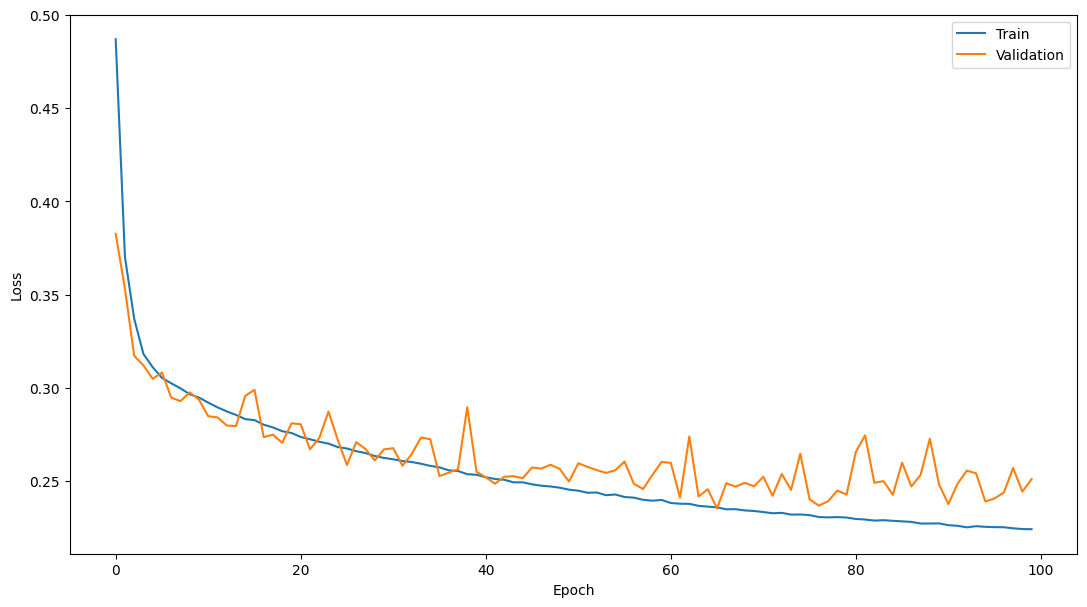

In [39]:
plt.figure(figsize=(13,7))
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(df_hist["epoch"], df_hist["loss"], label="Train")
plt.plot(df_hist["epoch"], df_hist["val_loss"], label = "Validation")
plt.legend()
plt.show()

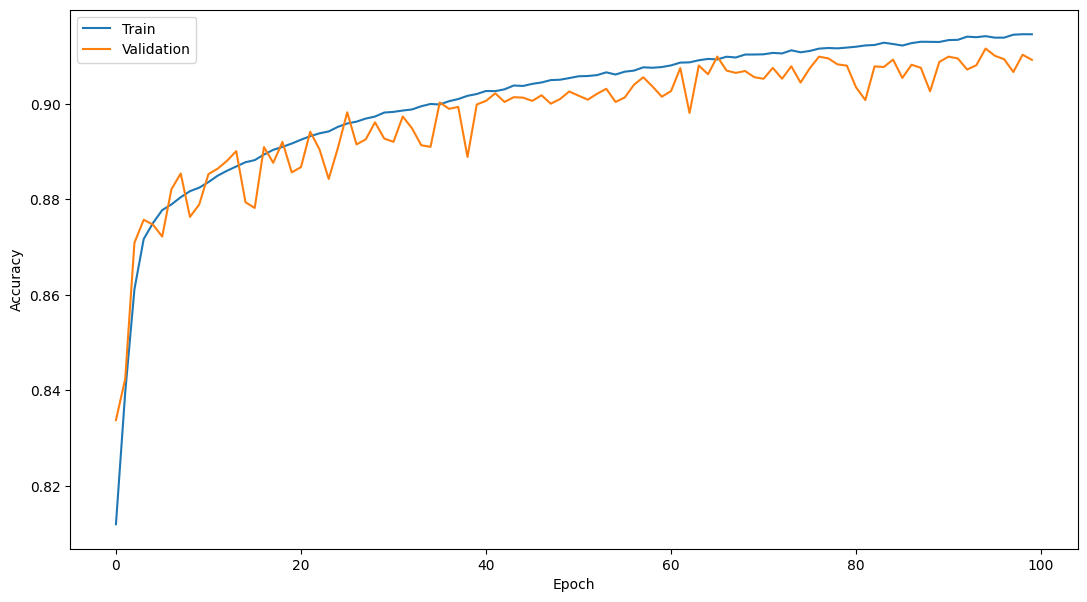

In [40]:
plt.figure(figsize=(13,7))
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(df_hist["epoch"], df_hist["accuracy"], label="Train")
plt.plot(df_hist["epoch"], df_hist["val_accuracy"], label = "Validation")
plt.legend()
plt.show()

### Balanced Datasets

In [41]:
mlp_sam = create_model()

**Subsample Dataset**

In [42]:
his_sam = mlp_sam.fit(X_under,
                      y_under,
                      epochs=100,
                      batch_size=1000,
                      verbose=1,
                      validation_data=(X_val, y_val))

Epoch 1/100
220/220 [==============================] - 3s 10ms/step - loss: 978.6343 - accuracy: 0.5403 - val_loss: 1.2381 - val_accuracy: 0.1844
Epoch 2/100
220/220 [==============================] - 2s 9ms/step - loss: 6.8598 - accuracy: 0.5545 - val_loss: 1.3842 - val_accuracy: 0.1771
Epoch 3/100
220/220 [==============================] - 2s 11ms/step - loss: 2.8397 - accuracy: 0.5784 - val_loss: 1.3876 - val_accuracy: 0.1771
Epoch 4/100
220/220 [==============================] - 2s 9ms/step - loss: 1.6435 - accuracy: 0.5887 - val_loss: 1.3889 - val_accuracy: 0.1771
Epoch 5/100
220/220 [==============================] - 2s 9ms/step - loss: 1.0087 - accuracy: 0.5914 - val_loss: 1.3942 - val_accuracy: 0.1771
Epoch 6/100
220/220 [==============================] - 2s 9ms/step - loss: 1.1692 - accuracy: 0.5912 - val_loss: 1.3547 - val_accuracy: 0.1771
Epoch 7/100
220/220 [==============================] - 2s 9ms/step - loss: 0.8174 - accuracy: 0.5912 - val_loss: 1.3410 - val_accuracy: 0.

In [43]:
res_sam = mlp_sam.evaluate(X_test, y_test, verbose=1)

print("Accuracy SubSampling:", round(res_sam[1], 4))

4204/4204 [==============================] - 5s 1ms/step - loss: 1.1890 - accuracy: 0.1796
Accuracy SubSampling: 0.1796


**SMOTE Dataset**

In [44]:
his_sam = mlp_sam.fit(X_smote,
                      y_smote,
                      epochs=100,
                      batch_size=1000,
                      verbose=1,
                      validation_data=(X_val, y_val))

Epoch 1/100
1034/1034 [==============================] - 8s 8ms/step - loss: 0.6932 - accuracy: 0.4997 - val_loss: 1.1627 - val_accuracy: 0.1790
Epoch 2/100
1034/1034 [==============================] - 8s 8ms/step - loss: 0.6932 - accuracy: 0.5001 - val_loss: 1.1645 - val_accuracy: 0.1789
Epoch 3/100
1034/1034 [==============================] - 8s 8ms/step - loss: 0.6931 - accuracy: 0.5004 - val_loss: 1.1552 - val_accuracy: 0.1790
Epoch 4/100
1034/1034 [==============================] - 8s 8ms/step - loss: 0.6932 - accuracy: 0.4996 - val_loss: 1.1573 - val_accuracy: 0.1789
Epoch 5/100
1034/1034 [==============================] - 8s 8ms/step - loss: 0.6932 - accuracy: 0.4996 - val_loss: 1.1526 - val_accuracy: 0.1792
Epoch 6/100
1034/1034 [==============================] - 8s 8ms/step - loss: 0.6932 - accuracy: 0.4992 - val_loss: 1.1596 - val_accuracy: 0.1788
Epoch 7/100
1034/1034 [==============================] - 8s 8ms/step - loss: 0.6931 - accuracy: 0.5004 - val_loss: 1.1584 - val_ac

In [45]:
res_sam = mlp_sam.evaluate(X_test, y_test, verbose=1)

print("Accuracy SMOTE:", round(res_sam[1], 4))

4204/4204 [==============================] - 5s 1ms/step - loss: 1.0207 - accuracy: 0.2205
Accuracy SMOTE: 0.2205


## Model Evaluation

### Classification Report

In [49]:
y_pred = mlp_model.predict(X_test)
y_pred = np.round(y_pred).astype(int)

4204/4204 [==============================] - 5s 1ms/step


In [50]:
print("Exactitud:    %.4f" % (accuracy_score(y_test, y_pred)))
print("Precisión:    %.4f" % (precision_score(y_test, y_pred, average="macro")))
print("Sensibilidad: %.4f" % (recall_score(y_test, y_pred, average="macro")))
print("F1-score:     %.4f" % (f1_score(y_test, y_pred, average="macro")))

Exactitud:    0.8923
Precisión:    0.8676
Sensibilidad: 0.7342
F1-score:     0.7773


In [51]:
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.8988    0.9794    0.9374    110629
           1     0.8364    0.4890    0.6172     23869

    accuracy                         0.8923    134498
   macro avg     0.8676    0.7342    0.7773    134498
weighted avg     0.8877    0.8923    0.8805    134498



### Confusion Matrix

In [55]:
cm_mlp = confusion_matrix(y_test, y_pred, normalize="all")
print(cm_mlp)

[[0.80555845 0.01697423]
 [0.09067793 0.08678939]]


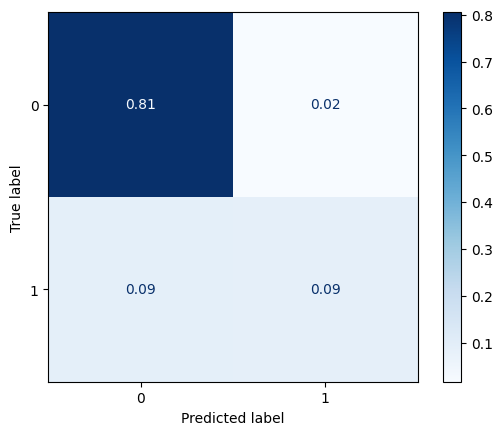

In [56]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm_mlp)
disp.plot(cmap="Blues", values_format=".2f")

### ROC Curve & AUC

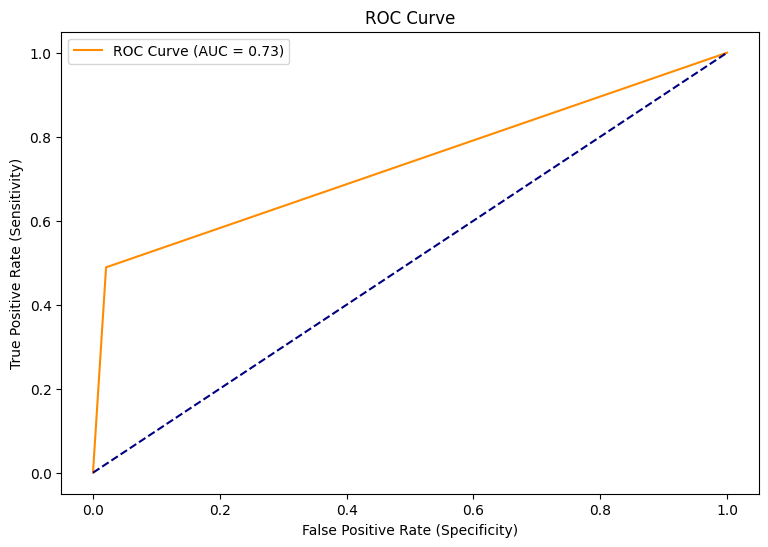

In [57]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(9, 6))
plt.plot(fpr, tpr, color="darkorange", label="ROC Curve (AUC = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")

plt.title("ROC Curve")
plt.xlabel("False Positive Rate (Specificity)")
plt.ylabel("True Positive Rate (Sensitivity)")
plt.legend()
plt.show()

## Model Pipeline

### Create the Pipeline

In [ ]:
# class XGBoostModel(BaseEstimator, TransformerMixin):
#     def __init__(self):
#         self.xgboost = XGBClassifier(learning_rate=0.2,
#                                      max_depth=10,
#                                      random_state=rnd_xgb)

#     def fit(self, X, y):
#         self.xgboost.fit(X, y)
#         return self

#     def predict(self, X, y=None):
#         y_pred = self.xgboost.predict(X)
#         return y_pred

In [ ]:
# xgboost_custom = Pipeline([
#     ("custom_model", XGBoostModel())
#     ])

### Test the Pipeline

**Internal Partition**

In [ ]:
# xgboost_custom.fit(X_train, y_train)

# y_pred = xgboost_custom.predict(X_val)

In [ ]:
# print("Exactitud:    %.4f" % (accuracy_score(y_val, y_pred)))
# print("Precisión:    %.4f" % (precision_score(y_val, y_pred, average="macro")))
# print("Sensibilidad: %.4f" % (recall_score(y_val, y_pred, average="macro")))
# print("F1-score:     %.4f" % (f1_score(y_val, y_pred, average="macro")))

Exactitud:    0.9562
Precisión:    0.9292
Sensibilidad: 0.9190
F1-score:     0.9240


**External Partition**

In [ ]:
# X_train_val = pd.concat([X_train, X_val], axis=0)
# y_train_val = pd.concat([y_train, y_val], axis=0)

# xgboost_custom.fit(X_train_val, y_train_val)

# y_pred = xgboost_custom.predict(X_test)

In [ ]:
# print("Exactitud:    %.4f" % (accuracy_score(y_test, y_pred)))
# print("Precisión:    %.4f" % (precision_score(y_test, y_pred, average="macro")))
# print("Sensibilidad: %.4f" % (recall_score(y_test, y_pred, average="macro")))
# print("F1-score:     %.4f" % (f1_score(y_test, y_pred, average="macro")))

Exactitud:    0.9566
Precisión:    0.9311
Sensibilidad: 0.9185
F1-score:     0.9246


**The Best Model**

In [ ]:
# xgboost_custom.fit(X_train_val, y_train_val)

# y_pred = xgboost_custom.predict(X_test)

In [ ]:
# print("Exactitud:    %.4f" % (accuracy_score(y_test, y_pred)))
# print("Precisión:    %.4f" % (precision_score(y_test, y_pred, average="macro")))
# print("Sensibilidad: %.4f" % (recall_score(y_test, y_pred, average="macro")))
# print("F1-score:     %.4f" % (f1_score(y_test, y_pred, average="macro")))

Exactitud:    0.9566
Precisión:    0.9311
Sensibilidad: 0.9185
F1-score:     0.9246


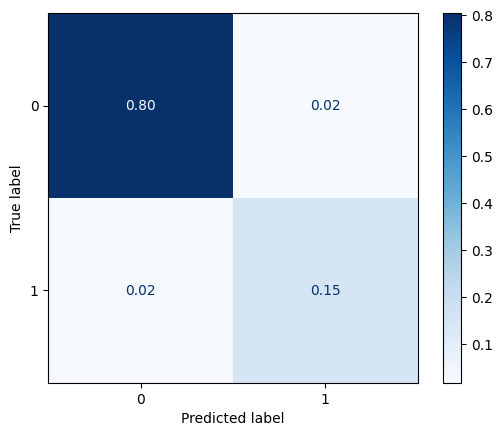

In [ ]:
# cm_xgb = confusion_matrix(y_test, y_pred, normalize="all")

# disp = ConfusionMatrixDisplay(confusion_matrix=cm_xgb,
#                               display_labels=xgb_model.classes_)
# disp.plot(cmap="Blues", values_format=".2f")

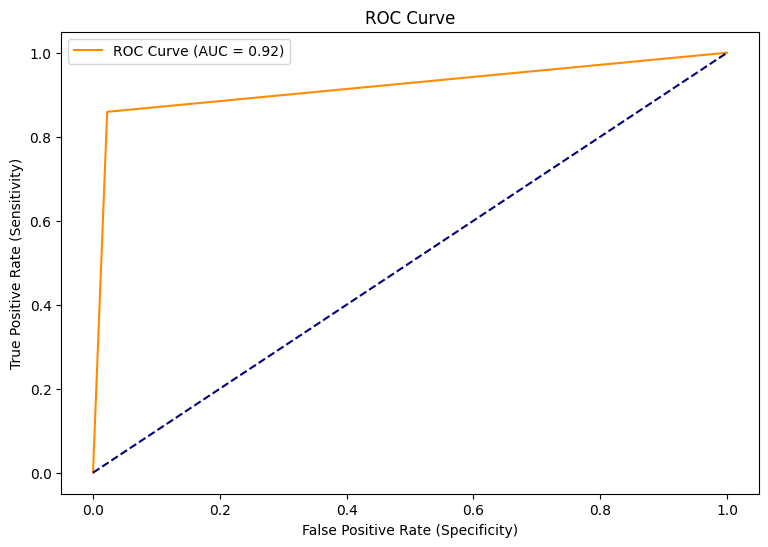

In [ ]:
# fpr, tpr, thresholds = roc_curve(y_test, y_pred)
# roc_auc = auc(fpr, tpr)

# plt.figure(figsize=(9, 6))
# plt.plot(fpr, tpr, color="darkorange", label="ROC Curve (AUC = %0.2f)" % roc_auc)
# plt.plot([0, 1], [0, 1], color="navy", linestyle="--")

# plt.title("ROC Curve")
# plt.xlabel("False Positive Rate (Specificity)")
# plt.ylabel("True Positive Rate (Sensitivity)")
# plt.legend()
# plt.show()

### Save the Model

In [ ]:
# try:
#     joblib.dump(xgboost_custom, xg_boost_model)

#     xgboost_model = joblib.load(xg_boost_model)
#     print(f"XGBoost Classifier is loaded...")

# except Exception as err:
#     print("Error:", str(err))

XGBoost Classifier is loaded...


In [ ]:
# y_pred = xgboost_model.predict(X_test)
# df_ = pd.concat([X_test, y_test, pd.DataFrame({"Pred": y_pred})], axis=1)

In [ ]:
# df_.sample(10)

,State,BankState,DifState,Sector,AppYear,AppMonth,Term,NoEmp,Secured,NewExist,Urban,Rural,RevLine,LowDoc,GrDisburs,GrApprov,ApprovSBA,SecuredSBA,Default,Pred
75913,31,49,1,5,39,9,5,3,0,0,1,0,0,0,50000,50000,25000,50,1,1
126444,35,38,0,12,37,12,84,150,0,0,1,0,0,0,350000,350000,262500,75,0,0
43412,9,30,1,1,39,3,55,9,0,0,0,1,0,0,49500,50000,25000,50,1,1
129203,35,38,0,20,25,8,120,67,0,0,0,0,0,0,529000,529000,529000,100,0,0
74556,43,45,1,12,30,7,288,4,1,0,0,0,0,0,223000,223000,167250,75,0,0
86497,4,17,1,8,43,4,84,3,0,0,1,0,1,0,129292,50000,25000,50,0,0
60384,9,30,1,16,43,9,90,4,0,0,1,0,0,0,200000,200000,100000,50,0,0
42102,10,12,0,16,38,9,120,2,0,0,1,0,0,0,320000,320000,240000,75,0,0
123628,43,47,0,20,31,2,84,75,0,0,0,0,0,0,285000,285000,242250,85,0,0
74079,34,37,0,0,45,7,36,37,0,1,0,1,0,0,40000,40000,20000,50,0,0
